In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Параметры распределения весов
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).normal_(-3, 0.1))

        # Параметры распределения смещений
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).normal_(-3, 0.1))

        # Априорное распределение
        self.prior_sigma = prior_sigma
        self.register_buffer('prior_mu', torch.tensor(0.0))

    @property
    def weight_sigma(self):
        # Обеспечиваем положительность стандартного отклонения
        return torch.log1p(torch.exp(self.weight_rho))

    @property
    def bias_sigma(self):
        return torch.log1p(torch.exp(self.bias_rho))

    def sample_weights(self):
        """Сэмплируем веса из апостериорного распределения"""
        # Reparameterization trick
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)

        weight = self.weight_mu + self.weight_sigma * weight_epsilon
        bias = self.bias_mu + self.bias_sigma * bias_epsilon

        return weight, bias

    def forward(self, x, sample=True):
        if sample:
            weight, bias = self.sample_weights()
        else:
            # Используем средние значения для предсказания
            weight, bias = self.weight_mu, self.bias_mu

        return F.linear(x, weight, bias)

    def kl_loss(self):
        """Вычисляем KL-дивергенцию между апостериорным и априорным распределениями"""
        # KL-дивергенция для нормальных распределений
        weight_kl = self._kl_gaussian(self.weight_mu, self.weight_sigma,
                                    self.prior_mu, self.prior_sigma)
        bias_kl = self._kl_gaussian(self.bias_mu, self.bias_sigma,
                                  self.prior_mu, self.prior_sigma)

        return weight_kl + bias_kl

    def _kl_gaussian(self, mu_q, sigma_q, mu_p, sigma_p):
        """KL-дивергенция между двумя нормальными распределениями"""
        kl = torch.log(sigma_p / sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2) - 0.5
        return kl.sum()

In [2]:
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, prior_sigma=1.0):
        super().__init__()

        layers = []
        prev_dim = input_dim

        # Скрытые слои
        for hidden_dim in hidden_dims:
            layers.append(BayesianLinear(prev_dim, hidden_dim, prior_sigma))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Выходной слой
        layers.append(BayesianLinear(prev_dim, output_dim, prior_sigma))

        self.network = nn.Sequential(*layers)
        self.layers = [layer for layer in self.network if isinstance(layer, BayesianLinear)]

    def forward(self, x, sample=True):
        return self.network(x)

    def kl_loss(self):
        """Суммарная KL-дивергенция для всех слоев"""
        total_kl = 0
        for layer in self.layers:
            total_kl += layer.kl_loss()
        return total_kl

In [3]:
def elbo_loss(model, x, y, num_samples=10, kl_weight=1.0):
    """
    Evidence Lower Bound (ELBO) loss
    ELBO = likelihood - KL-дивергенция
    """
    total_loss = 0
    total_likelihood = 0

    # Монте-Карло оценка
    for _ in range(num_samples):
        predictions = model(x, sample=True)

        # Гауссово правдоподобие (MSE)
        likelihood = -F.mse_loss(predictions, y, reduction='sum')
        total_likelihood += likelihood

    # Усредняем правдоподобие
    avg_likelihood = total_likelihood / num_samples

    # KL-дивергенция
    kl = model.kl_loss()

    # ELBO loss (минимизируем negative ELBO)
    elbo = avg_likelihood - kl_weight * kl
    return -elbo, avg_likelihood, kl

def train_bnn(model, x_train, y_train, epochs=1000, lr=0.01, num_samples=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Вычисляем loss с несколькими сэмплами
        loss, likelihood, kl = elbo_loss(model, x_train, y_train, num_samples)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 200 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item():.4f}, '
                  f'Likelihood = {likelihood.item():.4f}, KL = {kl.item():.4f}')

    return losses

Обучение BNN...
Epoch 0: Loss = 1272.8547, Likelihood = -58.1913, KL = 1214.6635
Epoch 200: Loss = 425.8847, Likelihood = -27.5151, KL = 398.3696
Epoch 400: Loss = 147.5094, Likelihood = -25.5018, KL = 122.0076
Epoch 600: Loss = 111.6053, Likelihood = -18.6962, KL = 92.9090
Epoch 800: Loss = 119.3798, Likelihood = -31.3965, KL = 87.9833
Epoch 1000: Loss = 113.2100, Likelihood = -29.3959, KL = 83.8141
Epoch 1200: Loss = 124.9818, Likelihood = -40.7440, KL = 84.2377
Epoch 1400: Loss = 104.4374, Likelihood = -19.5809, KL = 84.8565
Epoch 1600: Loss = 103.4607, Likelihood = -18.9992, KL = 84.4615
Epoch 1800: Loss = 106.5219, Likelihood = -21.6544, KL = 84.8676


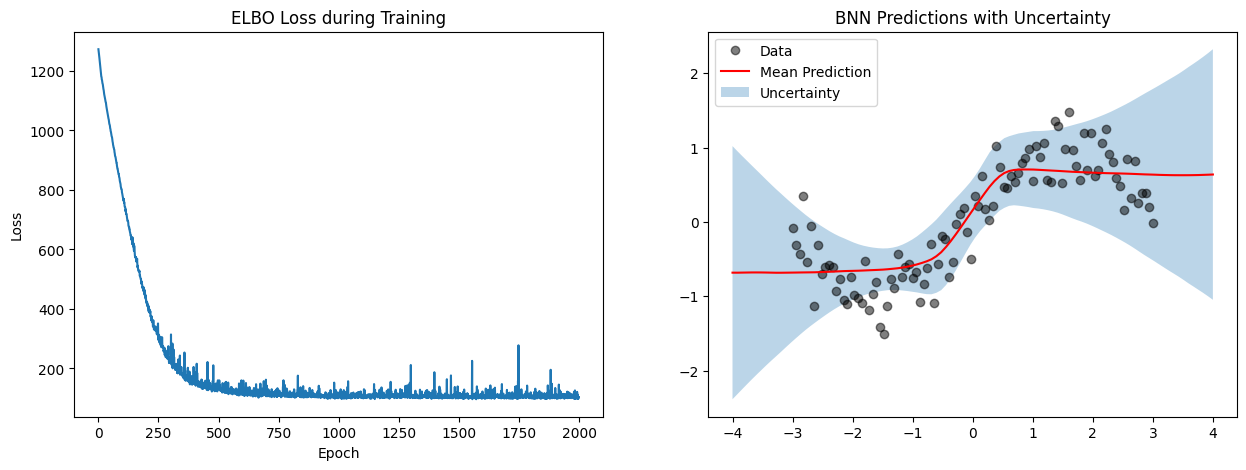

In [4]:
# Генерируем синтетические данные
def generate_data(n=100):
    x = torch.linspace(-3, 3, n).unsqueeze(1)
    y = torch.sin(x) + 0.3 * torch.randn(n, 1)
    return x, y

# Создаем и обучаем модель
x_train, y_train = generate_data(100)

model = BNN(input_dim=1, hidden_dims=[20, 20], output_dim=1, prior_sigma=1.0)

print("Обучение BNN...")
losses = train_bnn(model, x_train, y_train, epochs=2000, lr=0.01)

# Визуализация обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('ELBO Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Предсказания с uncertainty
plt.subplot(1, 2, 2)
x_test = torch.linspace(-4, 4, 100).unsqueeze(1)

# Множественные предсказания для оценки uncertainty
predictions = []
for _ in range(100):
    with torch.no_grad():
        pred = model(x_test, sample=True)
        predictions.append(pred.numpy())

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

plt.plot(x_train.numpy(), y_train.numpy(), 'ko', alpha=0.5, label='Data')
plt.plot(x_test.numpy(), mean_pred, 'r-', label='Mean Prediction')
plt.fill_between(x_test.squeeze().numpy(),
                 mean_pred.squeeze() - 2*std_pred.squeeze(),
                 mean_pred.squeeze() + 2*std_pred.squeeze(),
                 alpha=0.3, label='Uncertainty')
plt.legend()
plt.title('BNN Predictions with Uncertainty')
plt.show()

In [5]:
class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, prior_sigma=1.0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Параметры распределения
        self.weight_mu = nn.Parameter(
            torch.Tensor(out_channels, in_channels, kernel_size, kernel_size).normal_(0, 0.1)
        )
        self.weight_rho = nn.Parameter(
            torch.Tensor(out_channels, in_channels, kernel_size, kernel_size).normal_(-3, 0.1)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).normal_(0, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels).normal_(-3, 0.1))

        self.prior_sigma = prior_sigma
        self.register_buffer('prior_mu', torch.tensor(0.0))

    @property
    def weight_sigma(self):
        return torch.log1p(torch.exp(self.weight_rho))

    @property
    def bias_sigma(self):
        return torch.log1p(torch.exp(self.bias_rho))

    def sample_weights(self):
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)

        weight = self.weight_mu + self.weight_sigma * weight_epsilon
        bias = self.bias_mu + self.bias_sigma * bias_epsilon

        return weight, bias

    def forward(self, x, sample=True):
        if sample:
            weight, bias = self.sample_weights()
        else:
            weight, bias = self.weight_mu, self.bias_mu

        return F.conv2d(x, weight, bias, padding=self.kernel_size//2)

    def kl_loss(self):
        weight_kl = self._kl_gaussian(self.weight_mu, self.weight_sigma,
                                    self.prior_mu, self.prior_sigma)
        bias_kl = self._kl_gaussian(self.bias_mu, self.bias_sigma,
                                  self.prior_mu, self.prior_sigma)
        return weight_kl + bias_kl

    def _kl_gaussian(self, mu_q, sigma_q, mu_p, sigma_p):
        kl = torch.log(sigma_p / sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2) - 0.5
        return kl.sum()